# Úloha 4: Extrakce pravidel pro znalostní systém z náhodného lesa

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random


from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics 
from sklearn import tree

from ucimlrepo import fetch_ucirepo 

Načteme data podle návodu.

In [2]:
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
Xdata = breast_cancer_wisconsin_diagnostic.data.features 
ydata = breast_cancer_wisconsin_diagnostic.data.targets 

In [3]:
Xdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   radius1             569 non-null    float64
 1   texture1            569 non-null    float64
 2   perimeter1          569 non-null    float64
 3   area1               569 non-null    float64
 4   smoothness1         569 non-null    float64
 5   compactness1        569 non-null    float64
 6   concavity1          569 non-null    float64
 7   concave_points1     569 non-null    float64
 8   symmetry1           569 non-null    float64
 9   fractal_dimension1  569 non-null    float64
 10  radius2             569 non-null    float64
 11  texture2            569 non-null    float64
 12  perimeter2          569 non-null    float64
 13  area2               569 non-null    float64
 14  smoothness2         569 non-null    float64
 15  compactness2        569 non-null    float64
 16  concavit

In [4]:
ydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Diagnosis  569 non-null    object
dtypes: object(1)
memory usage: 4.6+ KB


## Příprava dat

Převedeme `Diagnosis` na `category` a pak pomocí `cat.codes` na číselnou hodnotu.

In [5]:
ydata = ydata.astype('category').apply(lambda x: x.cat.codes)

Rozdělíme data na trénovací a testovací pomocí `train_test_split`.
Rozdělení:
* 70% - trénovací
* 30% - testovací

In [6]:
random_seed = 42 #constant for random_state

Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size = 0.3, random_state = random_seed) 

## Random Forest

Zkusíme nejprve natrénovat náhodný les s výchozími parametry, tedy budeme mít les o 100 stromech.

In [7]:
forest = RandomForestClassifier()
forest.fit(Xtrain, ytrain.values.ravel())
print('accuracy score for Tree (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, forest.predict(Xtrain))))
print('accuracy score for Tree (test): {0:.6f}'.format(metrics.accuracy_score(ytest, forest.predict(Xtest))))

accuracy score for Tree (train): 1.000000
accuracy score for Tree (test): 0.970760


Výsledky jsou dobré. Zkoušel jsem ladit hyperparametry, ale výsledek nebyl lepší, tak jsem se rozhodl nepoužívat validační množinu a trénovat na větším počtu dat.

## Extrakce pravidel z každého stromu

Sloučil jsem data do jednoho datasetu. Budu ho potřebovat k zjištění názvů sloupců.

In [8]:
data = Xdata.join(ydata["Diagnosis"])

Pro vizualizaci jednoho ze stromů jsem použil metodu `plot_tree` z knihovny `sklearn`.

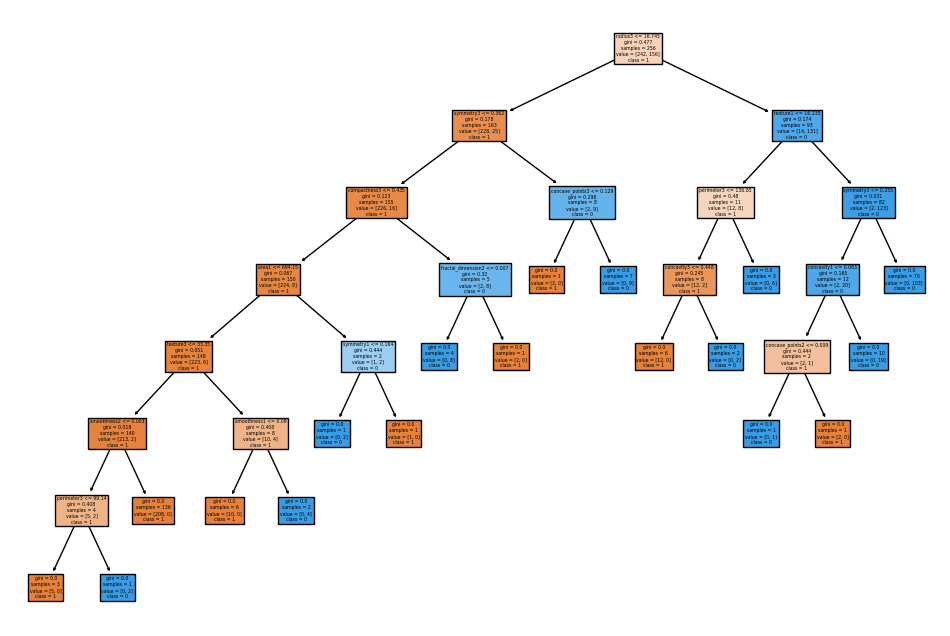

In [9]:
plt.figure(figsize=(12, 8))
tree.plot_tree(forest.estimators_[0], feature_names=data.columns[:-1], class_names=data['Diagnosis'].unique().astype(str), filled=True)
plt.show()

Vytvořil jsem prázdný seznam pravidel.

In [10]:
rules = []

Napsal jsem funkci `get_tree_rules`, která rekurzivně prochází strom od kořene ke listům a zaznamenává jednotlivé části pravidel (ty vznikají při přechodu mezi uzly) do tuple ve formátu (`column_name`, `<` or `>=`, `threshold`). Takové části pravidel spojujeme do seznamu `rule`, a když dosáhneme listu, vložíme tento seznam do globálního seznamu pravidel `rules`.

In [11]:
def get_tree_rules(node, rule, tree):
    if tree.children_left[node] != -1 or tree.children_right[node] != -1:
        name = data.columns[:-1][tree.feature[node]]
        threshold = tree.threshold[node]
        
        rule.append((name, "<", threshold))
        get_tree_rules(tree.children_left[node], rule, tree)
        
        rule.append((name, ">=", threshold))
        get_tree_rules(tree.children_right[node], rule, tree)
    else:
        rules.append((np.argmax(tree.value[node][0]), rule.copy()))
        rule.clear()

Aplikujeme funkci `get_tree_rules` na celý les, tedy postupně na každý strom v lese.

In [12]:
for tree_idx, tree in enumerate(forest.estimators_):
    rl = []
    get_tree_rules(0, rl, tree.tree_)

In [13]:
len(rules)

1743

## Hodnotící funkce

Rozměry matice, do které budeme ukládat výstup pravidel pro jednotlivé záznamy z trénovací množiny.

In [14]:
m = Xtrain.shape[0] 
n = len(rules)

Převedeme trénovací dataset na seznam seznamů n-tic, což usnadní jeho vkládání do pravidel.

In [15]:
result = [list(row.items()) for row in Xtrain.to_dict('records')]

`RsCoverage` je matice, která v řádcích obsahuje výstupy jednoho pravidla pro jednotlivé položky trénovacího datasetu.

In [16]:
RsCoverage = np.zeros((n, m))
RsCoverage[0].shape

(398,)

Funkce `match` vezme jeden řádek datasetu a zkouší na něj aplikovat pravidlo. Vezme hodnotu příznaku a jeho název a porovná je s jednotlivými částmi pravidla. Pokud takovou část nalezne, zvýší proměnnou `correct` a pokračuje v procházení záznamu. Pokud existuje mapování vstupního záznamu na vstupní pravidlo, vrátí výsledek pravidla, jinak -1.

In [17]:
def match(rule, sample):
    correct = 0
    for term in sample:
        for rule_term in rule[1]:
            if rule_term[1] == '<':
                if (rule_term[0] == term[0]) and (term[1] < rule_term[2]):
                    correct += 1
                    break
            else:
                if (rule_term[0] == term[0]) and (term[1] >= rule_term[2]):
                    correct += 1
                    break
    if correct == len(rule[1]):
        return rule[0]
    return -1

Pomocí funkce `match` vypočítáme hodnoty pro všechny kombinace a zaznamenáme výsledek do matice `RsCoverage`.

In [18]:
i = 0
j = 0
for res in result:
    for rule in rules:
        RsCoverage[i][j] = match(rule, res)
        i += 1
    j += 1
    i = 0   

In [19]:
RsCoverage

array([[ 0., -1., -1., ..., -1., -1., -1.],
       [-1., -1.,  1., ..., -1.,  1., -1.],
       [-1.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1.,  1., ..., -1.,  1., -1.]])

Funkce `ruleScore` vypočítá kvalitu pravidel pomocí matice `RsCoverage` a vzorce `((correct - nic) / (correct + nic)) + (correct / (nic + k))`. Vezme jeden řádek matice `RsCoverage` a zjistí, kolik záznamů bylo možné aplikovat na aktuální pravidlo. Na základě toho spočítá skóre tohoto pravidla.
* correct ... počet správně klasifikovaných vzorků* nic  ... počet nesprávně kalsifikovaných vzorků

In [20]:
def ruleScore(rule_result):
    result = []
    j = 0
    k = 0.00000000000001
    for point in rule_result:
        correct = 0
        for arr in point:
            if arr != -1:
                correct += 1
        nic = RsCoverage[0].shape[0] - correct
        score = ((correct - nic)/(correct + nic)) + (correct/(nic + k))
        result.append((round(score, 2), j)) 
        j += 1
    return result

In [21]:
correct = ruleScore(RsCoverage)
len(correct)

1743

Seřadíme pravidla podle skóre, tedy od nejvíce užitečného pravidla k nejméně užitečnému.

In [22]:
correct.sort(key=lambda x: x[0], reverse=True)

## Hill climbing

Funkce `HeuristicSearch` najde souseda (podmnožinu pravidel). Pravidlo přidáme na základě vstupního parametru `k`. 
* `k` musí být větší než 0, protože nejlepší pravidlo již je obsaženo v sadě pravidel.

In [23]:
def HeuristicSearch(rule_set, k):
    if (k > 0) and (correct[k] not in rule_set):
        rule_set.append(correct[k])
    return rule_set

Funkce `Accuracy` spočítá přesnost pravidel na trénovacích datech. Použije již existující funkci `match`, která vrátí predikci pravidla pro vstupní datový bod.

In [24]:
def Accuracy(rule_set):
    prediction = []
    correct = 0
    tmp = ytrain.to_numpy()
    for res in result:
        for rule in rules:
            from_match = match(rule, res)
            if from_match != -1:
                prediction.append(from_match)
                break

    for i in range(0, len(prediction)):
        if prediction[i] == tmp[i][0]:
            correct += 1
    acc = correct / len(prediction)
    return acc

Parametry Hill climbingu:
1. `N` - počet pravidel v počáteční sadě pravidel.
2. `MaxIteration` - maximální počet iterací Hill climbingu.
3. `iniRs` - počáteční množina pravidel.
4. `bestRs` - nejlepší množina pravidel.

In [25]:
N = 1
MaxIteration = 3000
iniRs = correct[:N]
bestRs = iniRs

Provedeme `MaxIteration` iterací a budeme porovnávat přesnost nalezené podmnožiny pravidel s nejlepší. Pokud nalezneme lepší výsledek, pak zkopírujeme tuto množinu do proměnné `bestRs`. Pak resetujeme množinu pravidel tak, že náhodně přidáme několik pravidel, odebereme nebo nezměníme pravidlo.

In [26]:
k = 0
for i in range(0, MaxIteration):
    
    impRs = HeuristicSearch(iniRs, k)
    
    if Accuracy(impRs) > Accuracy(bestRs):
        bestRs = impRs.copy()
        
    if (N+k) < len(correct):
        impRs = correct[0:(N+k)]
        k = random.randint(-1,5)

Přesnost nejlepší sady pravidel na trénovacích datech.

In [27]:
Accuracy(bestRs)

0.8618090452261307

Funkce calcPerformance provede totéž jako funkce Accuracy, ale na testovacích datech.

In [28]:
def calcPerformance(rule_set):
    prediction = []
    correct = 0
    temp = ytest.to_numpy()
    result_test = [list(row.items()) for row in Xtest.to_dict('records')]
    for res in result_test:
        for rule in rules:
            from_match = match(rule, res)
            if from_match != -1:
                prediction.append(from_match)
                break

    for i in range(0, len(prediction)):
        if prediction[i] == temp[i][0]:
            correct += 1
    acc = correct / len(prediction)
    return acc

Přesnost nejlepší sady pravidel na testovacích datech.

In [29]:
calcPerformance(bestRs)

0.8771929824561403

RScore a index pravidla

In [30]:
bestRs

[(198.99, 1357),
 (99.48, 622),
 (79.57, 457),
 (79.57, 222),
 (132.65, 1230),
 (132.65, 913)]

## Rules

Pravidla jsem zapsal ve formátu `IF THEN` do souboru `rules.txt`.

In [33]:
f = open("rules.txt", "w")
for dt in bestRs:
    str = "IF "
    sz = len(rules[dt[1]][1])
    cnt = 0
    for terms in rules[dt[1]][1]:
        str += f"{terms[0]} {terms[1]} {terms[2]} "
        cnt += 1
        if cnt != sz:
            str += "AND "
    str += f"THEN {rules[dt[1]][0]}\n"            
    f.write(str)
f.close()